# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания (значение метрики RMSE должно быть меньше 2500);
- скорость предсказания;
- время обучения.

Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Эти редкие случаи легко пропустить, если всегда применять только бустинг. Поэкспериментируйте и сравните характеристики моделей: время обучения, время предсказания, точность результата.

## Описание данных

- Признаки
    - DateCrawled — дата скачивания анкеты из базы
    - VehicleType — тип автомобильного кузова
    - RegistrationYear — год регистрации автомобиля
    - Gearbox — тип коробки передач
    - Power — мощность (л. с.)
    - Model — модель автомобиля
    - Kilometer — пробег (км)
    - RegistrationMonth — месяц регистрации автомобиля
    - FuelType — тип топлива
    - Brand — марка автомобиля
    - NotRepaired — была машина в ремонте или нет
    - DateCreated — дата создания анкеты
    - NumberOfPictures — количество фотографий автомобиля
    - PostalCode — почтовый индекс владельца анкеты (пользователя)
    - LastSeen — дата последней активности пользователя
- Целевой признак
    - Price — цена (евро)

Импортируем необходимые модули.

In [1]:
import pandas as pd
import sweetviz as sv

C:\Anaconda\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Подготовка данных

In [2]:
autos_path = "./datasets/autos.csv"
df = pd.read_csv(autos_path)
display(df.head())
df.info()
df.isna().sum()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Можно видеть, что в категориальных данных содержится значительное количество пропусков.

Удалим малоинформативные колонки.

In [3]:
cols_to_drop = ['DateCrawled', 'DateCreated', 'RegistrationMonth', 'PostalCode', 'LastSeen']
df = df.drop(columns=cols_to_drop)

Проверим количество уникальных значений в колонке с количеством фотографий.

In [4]:
print(df['NumberOfPictures'].unique())

[0]


Удалим ее как малоинформативную.

In [5]:
df = df.drop('NumberOfPictures', axis=1)

Проверим уникальные значения в категориальных колонках на наличие опечаток.

In [6]:
# cat_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
# num_cols = ['Price', 'RegistrationYear', 'Power', 'Kilometer']

In [7]:
for col in df.columns:
    if df[col].dtype == 'object':
        print(col)
        print(df[col].unique())

VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Gearbox
['manual' 'auto' nan]
Model
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore'

Опечатки не обнаружены.

Сделаем аналогичную процедуру для числовых данных.

Заменим пропущенные значения на unknown.

In [8]:
df = df.fillna('unknown')
print('Количество пропущенных значений:')
df.isna().sum()

Количество пропущенных значений:


Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
dtype: int64

Проведем исследовательский анализ данных с помощью пакета sweetviz.

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:02 -> (00:00 left)



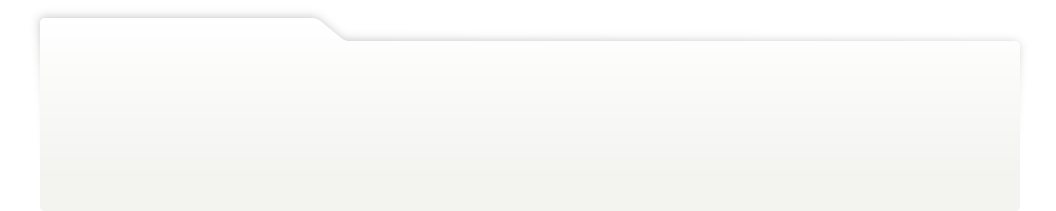
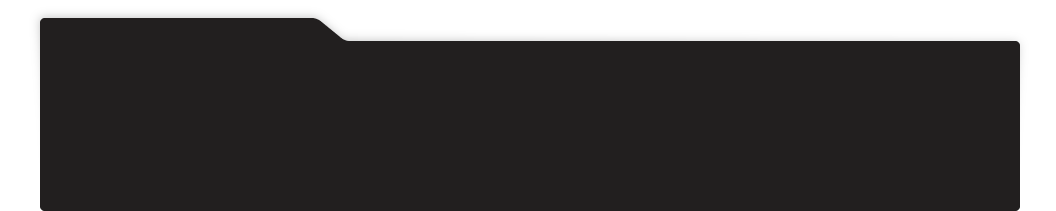
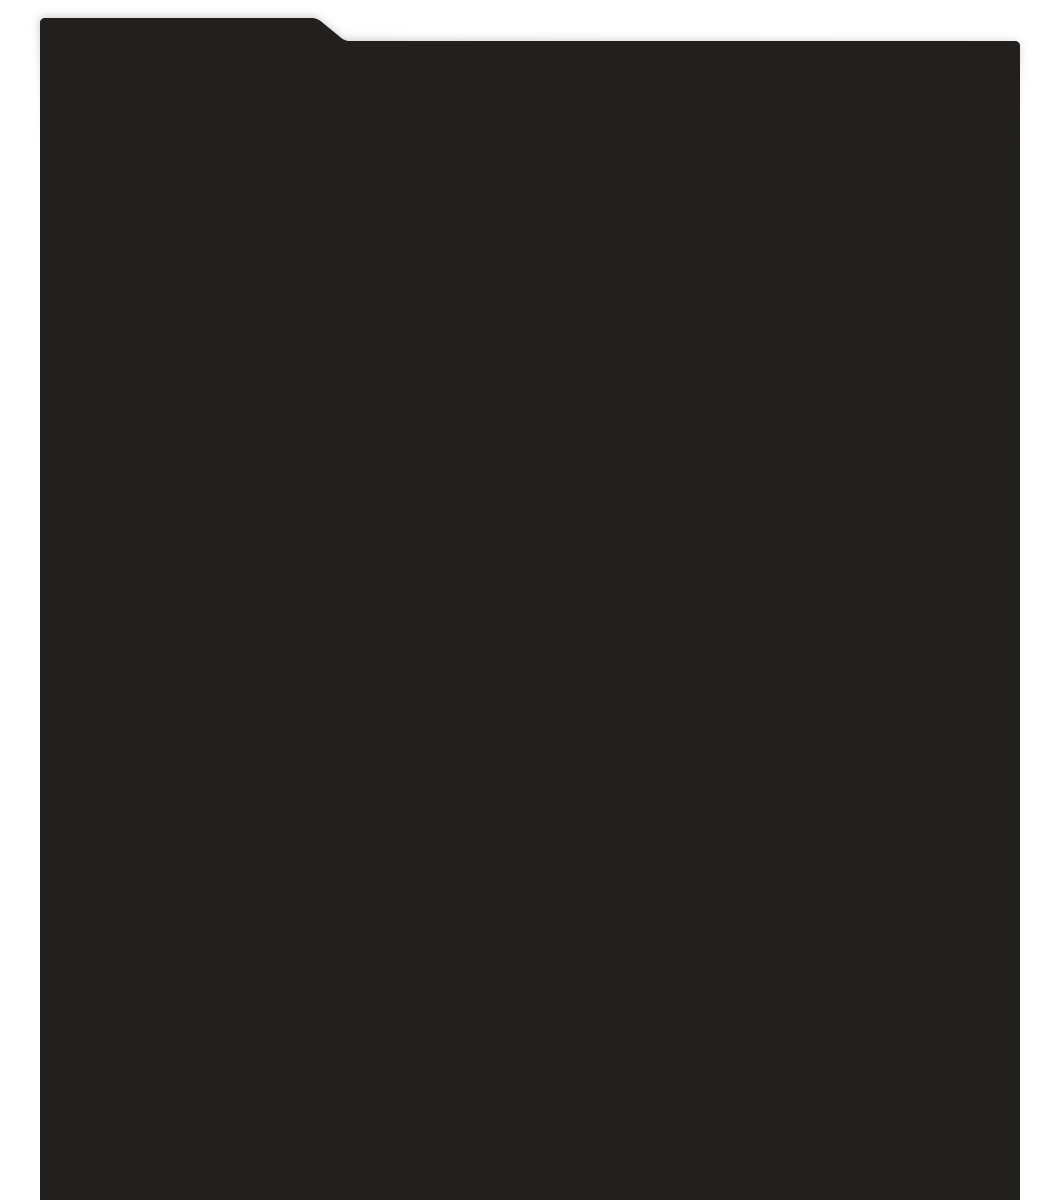
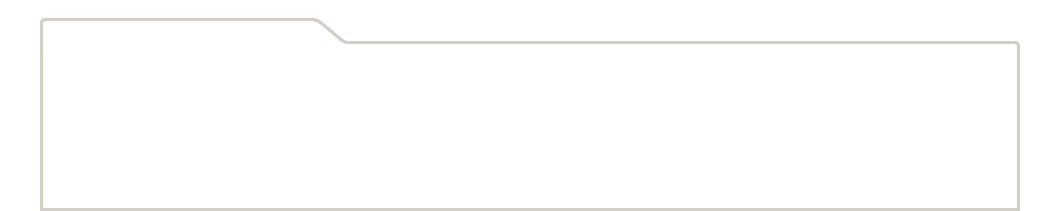
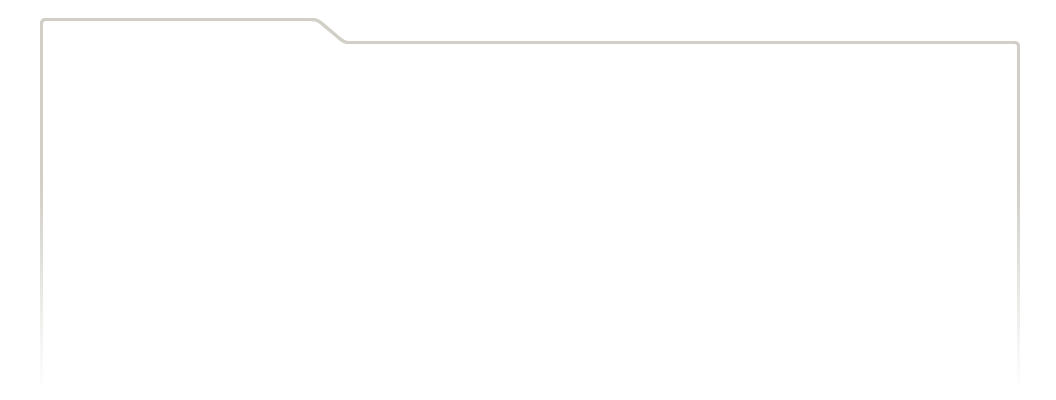
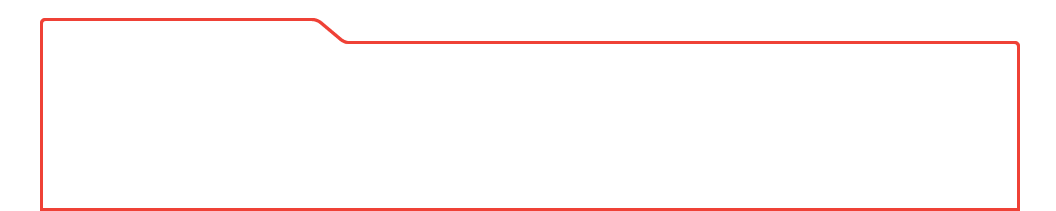
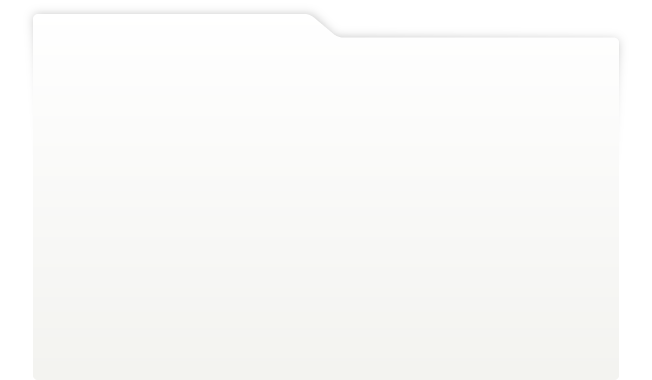
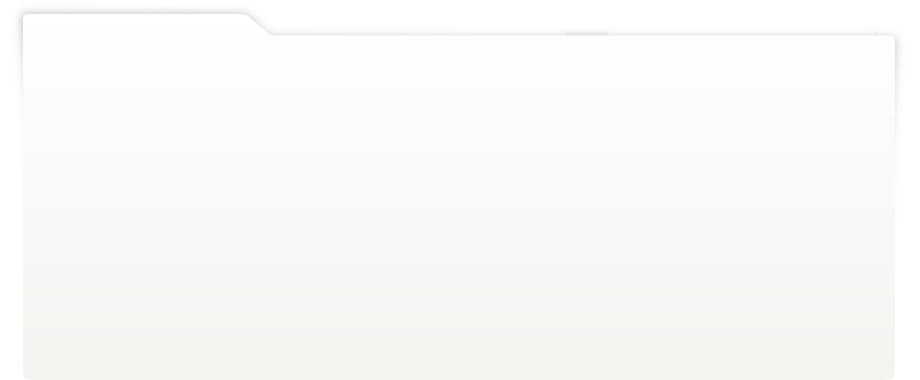
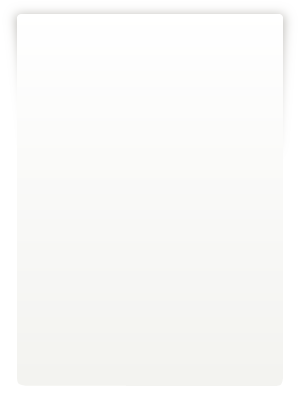
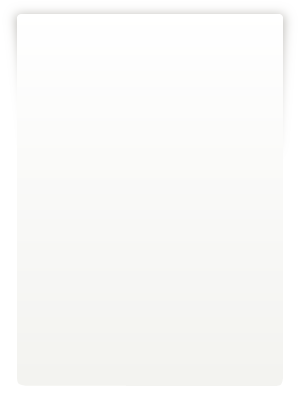
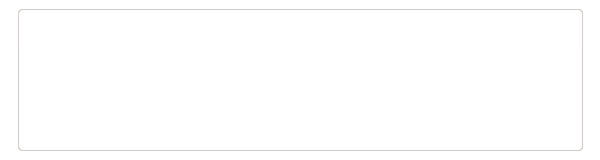
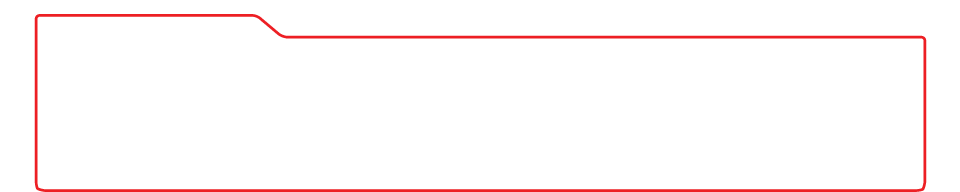
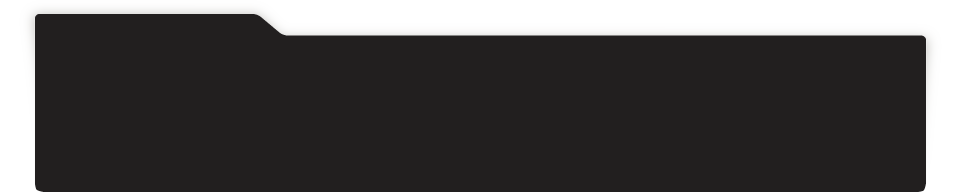
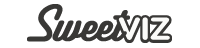
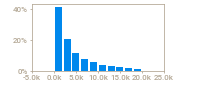
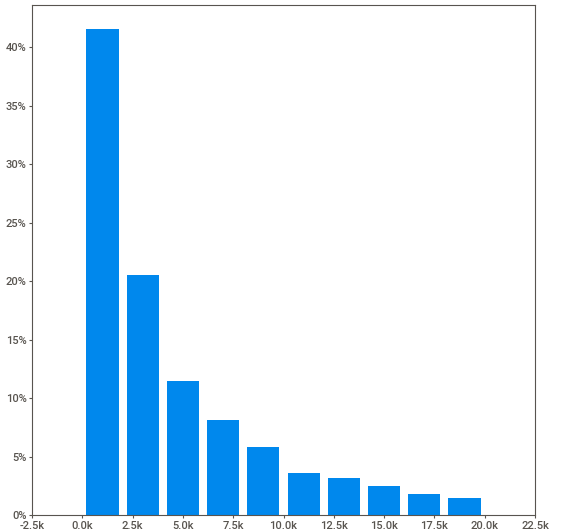
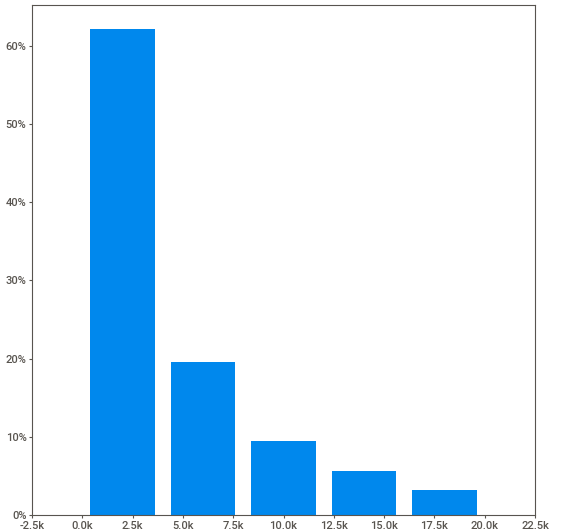
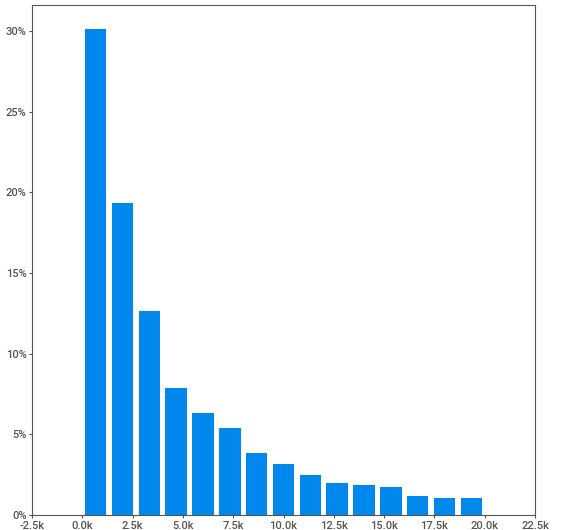
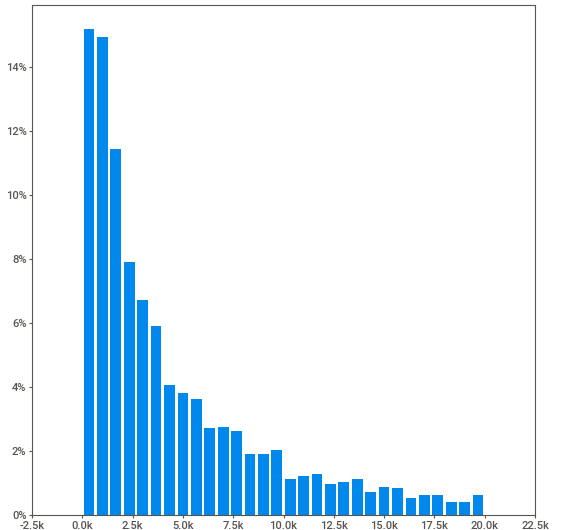
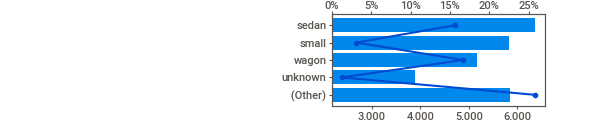
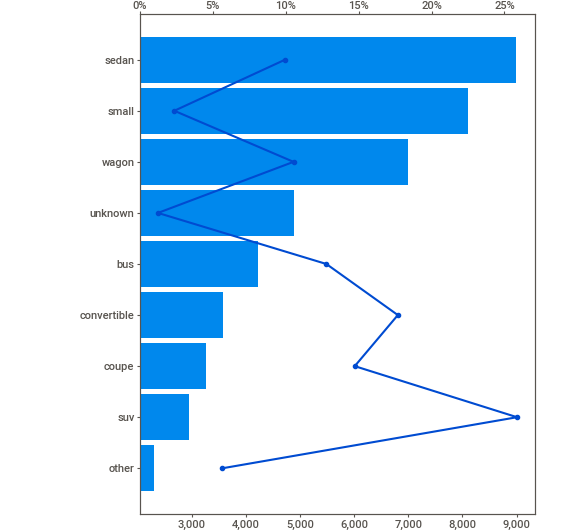
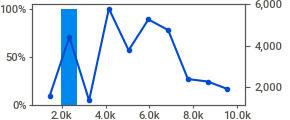
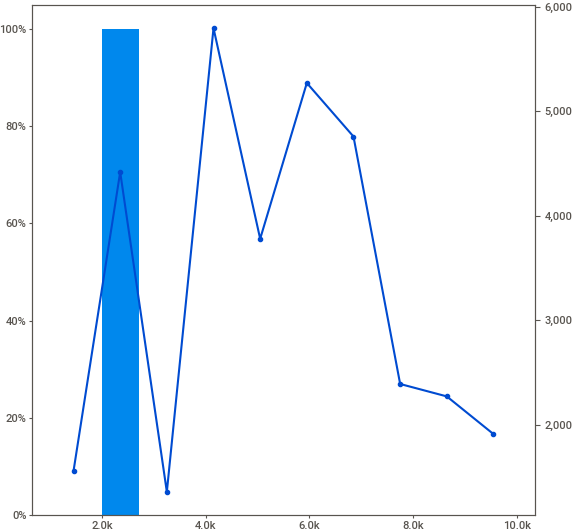
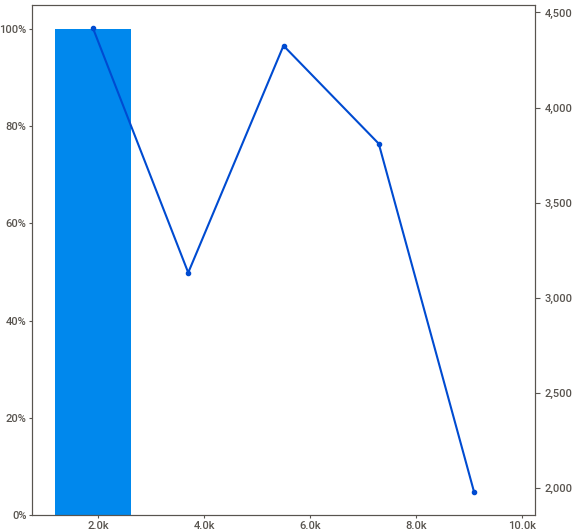
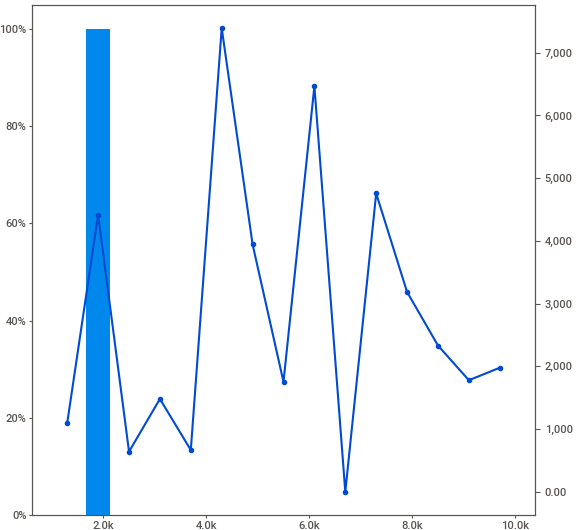
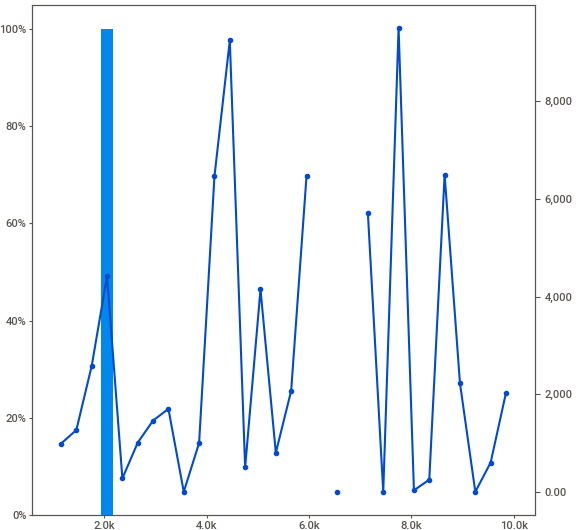
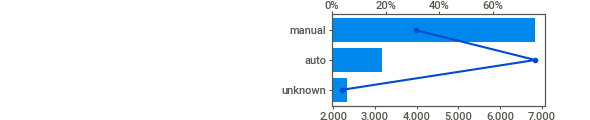
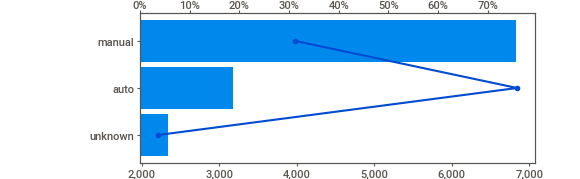
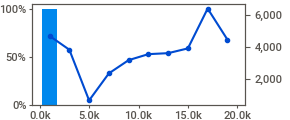
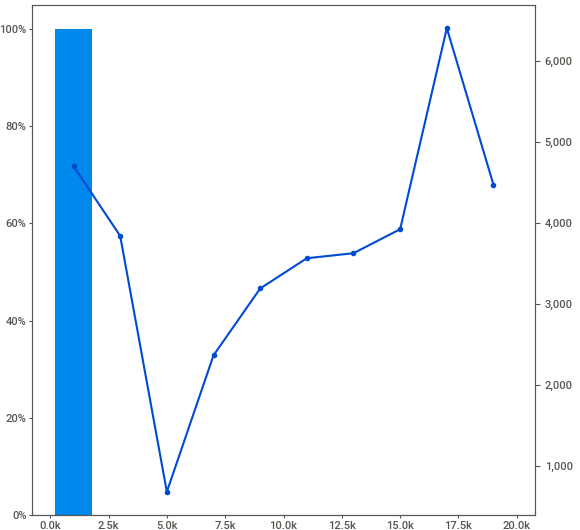
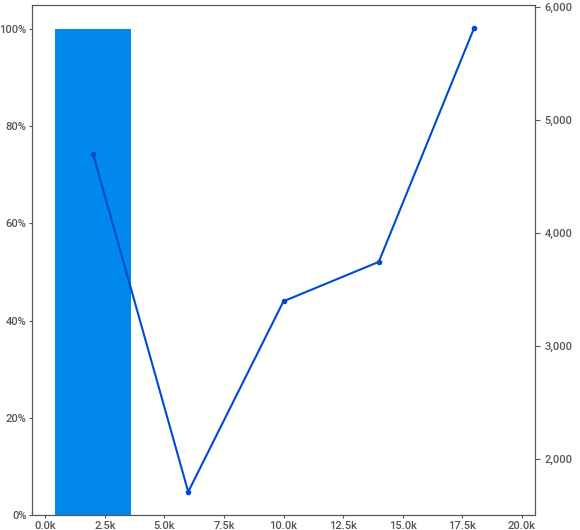
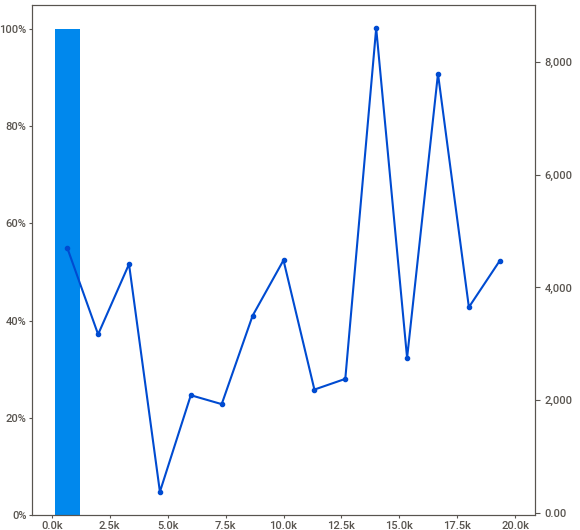
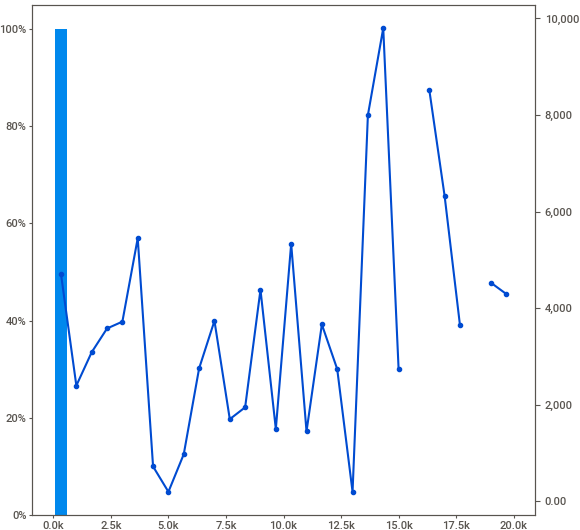
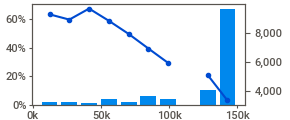
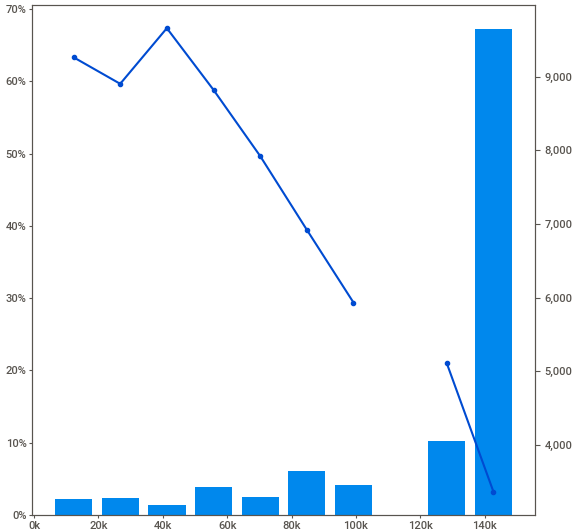
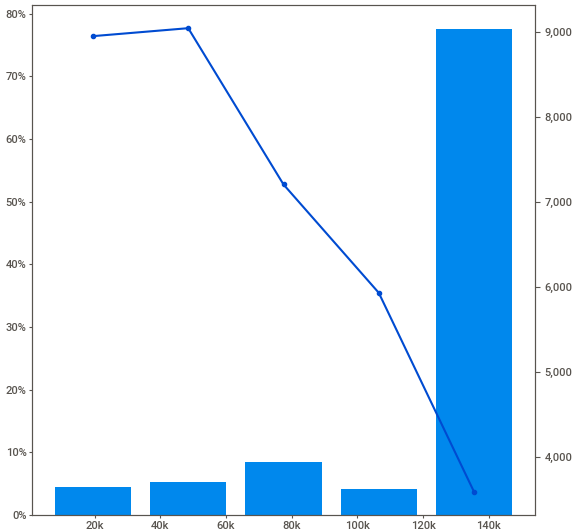
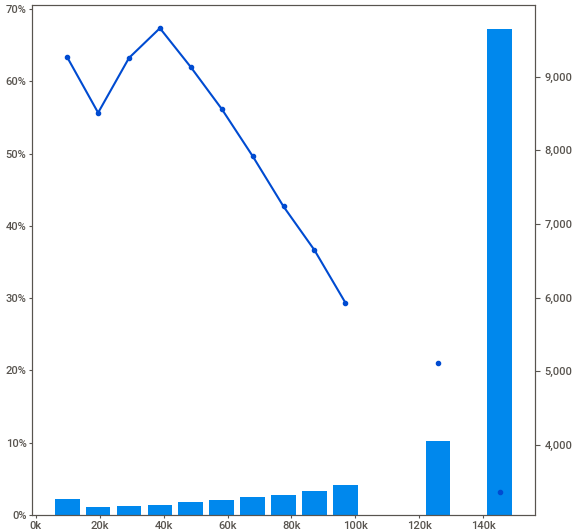
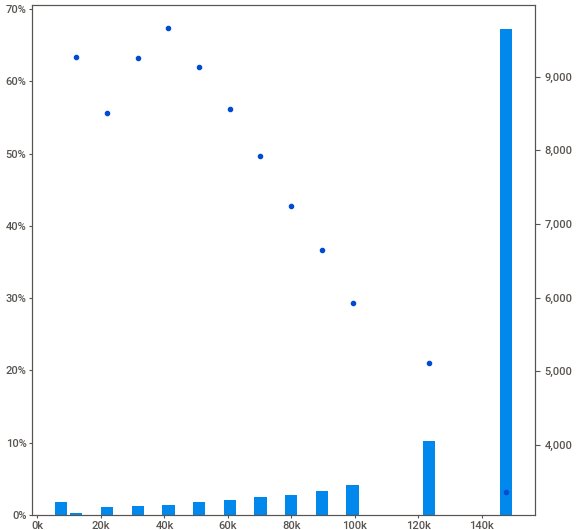
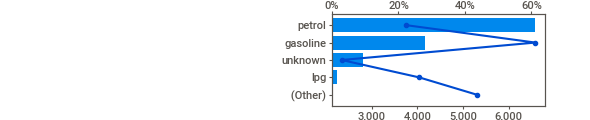
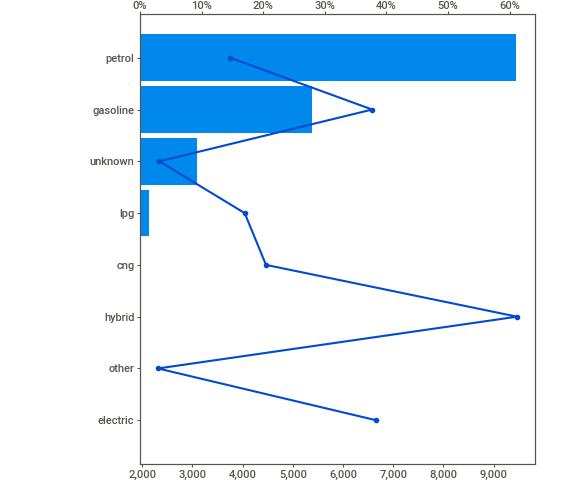
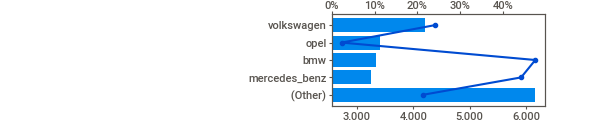
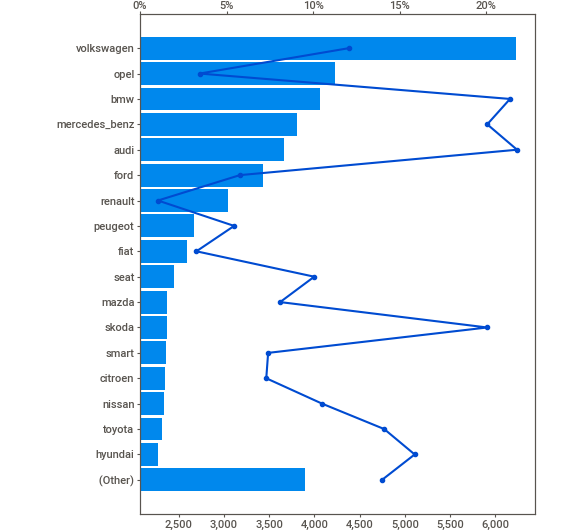
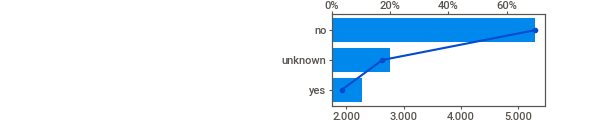
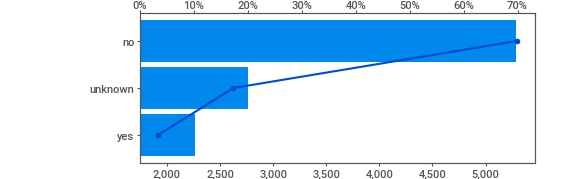
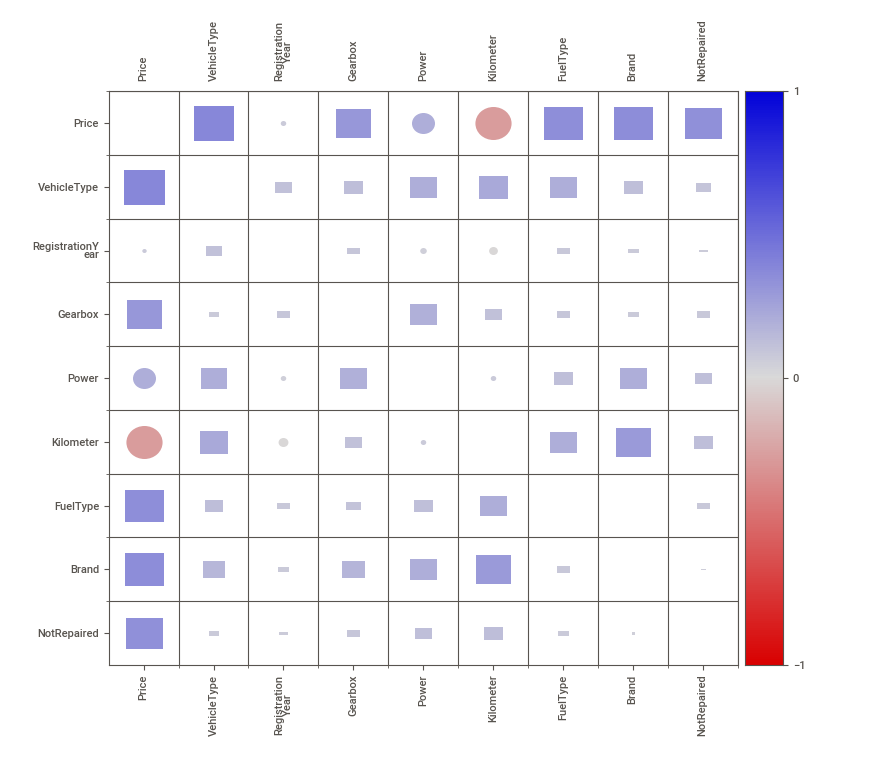
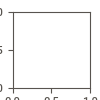

In [9]:
report_autos = sv.analyze((df, 'autos_df'), target_feat='Price')
report_autos.show_notebook()

Исследовательский анализ данных выявил ошибки в колонка с годом регистрации и мощностью автомобиля. В колонке с годом регистрации присутствуют недостоверно малые значения 1000 и недостоверно большие значения 9999. В колонке с мощностью также обнаруживаются крайне малые значения (0) и крайне большие значения (20000) лошадиных сил.

Возможно, что некорректные данные в столбце с годом регистрации появились из-за того, что информации была записана в днях начиная с начала 1970 года. Поэтому заменим значения меньше 1970 и больше 2022 на значение, равное сумме 1970 и целочисленного деления некорректного значения на 365.

Высокие значения в столбце с мощностью автомобиля может быть связан с неправильным форматом данных (Ватты вместо лошадиных сил), поэтому значения выше 500 (примерная мощность грузовика) заменим на значение, равное частному некорректного значения и 736, т.к. 1 л.с. = 736 Вт. Нулевые значения в рассматриваемом столбце могли появиться из-за того, что владелец не знает мощности своего автомобиля и поэтому не указал его, заменим его на медианное.

In [10]:
df['RegistrationYear'] = df['RegistrationYear'].apply(lambda x: x // 365 + 1970 if (x > 2022 or x < 1970) else x)

df['Power'] = df['Power'].apply(lambda x: x // 736 if x > 500 else x)
power_median = df['Power'].median()
df['Power'] = df['Power'].apply(lambda x: power_median if x == 0 else x)

df.describe()

,Price,RegistrationYear,Power,Kilometer
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2003.138091,118.202165,128211.172535
std,4514.158514,7.169394,50.688795,37905.341530
min,0.000000,1970.000000,1.000000,5000.000000
25%,1050.000000,1999.000000,83.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,141.000000,150000.000000
max,20000.000000,2019.000000,500.000000,150000.000000


## Анализ моделей

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей